# Kelvin-Helmholtz Instability

<img src="http://www.flame.org/~cdoswell/SuptorRoles/Vortex%20Sheet%20Model%20copy.jpg" width="254" height="300" />

(image: Chuck Doswell)

We will simulate the incompressible Kelvin-Helmholtz problem.  We non-dimensionalize the problem by taking the box height to be one and the jump in velocity to be one.  Then the Reynolds number is given by

$$ \mathrm{Re} = \frac{U H}{\nu} = \frac{1}{\nu}. $$

We use no slip boundary conditions, and a box with aspect ratio $L/H=2$.  The initial velocity profile is given by a hyperbolic tangent, and only a single mode is initially excited.  We will also track a passive scalar which will help us visualize the instability.

First, we import the necessary modules.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from dedalus import public as de
from dedalus.extras import flow_tools
import time
from IPython import display

Here, we set logging to `INFO` level. Currently, by default, Dedalus sets its logging output to `DEBUG`, which produces more info than we need here.

In [3]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

To perform an initial value problem (IVP) in Dedalus, you need three things:

1. A domain to solve the problem on
2. Equations to solve
3. A timestepping scheme

## Problem Domain

First, we will specify the domain.  Domains are built by taking the direct product of bases.  Here we are running a 2D simulation, so we will define $x$ and $y$ bases.  From these, we build the domain.

In [4]:
#Aspect ratio 2
Lx, Ly = (2., 1.)
nx, ny = (192, 96)

# Create bases and domain
x_basis = de.Fourier('x', nx, interval=(0, Lx), dealias=3/2)
y_basis = de.Chebyshev('y',ny, interval=(-Ly/2, Ly/2), dealias=3/2)
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

The last basis ($z$ direction) is represented in Chebyshev polynomials.  This will allow us to apply interesting boundary conditions in the $z$ direction.  We call the other directions (in this case just $x$) the "horizontal" directions.  The horizontal directions must be "easy" in the sense that taking derivatives cannot couple different horizontal modes.  Right now, we have Fourier and Sin/Cos series implemented for the horizontal directions, and are working on implementing spherical harmonics.

## Equations

Next we will define the equations that will be solved on this domain.  The equations are

$$ \partial_t u + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} u + \partial_x p = \frac{1}{{\rm Re}} \nabla^2 u $$
$$ \partial_t v + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} v + \partial_y p = \frac{1}{{\rm Re}} \nabla^2 v $$
$$ \boldsymbol{\nabla}\boldsymbol{\cdot}\boldsymbol{u} = 0 $$
$$ \partial_t s + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} s = \frac{1}{{\rm Re}{\rm Sc}} \nabla^2 s $$

The equations are written such that the left-hand side (LHS) is treated implicitly, and the right-hand side (RHS) is treated explicitly.  The LHS is limited to only linear terms, though linear terms can also be placed on the RHS.  Since $y$ is our special direction in this example, we also restrict the LHS to be at most first order in derivatives with respect to $y$.

We also set the parameters, the Reynolds and Schmidt numbers.

In [5]:
Reynolds = 1e4
Schmidt = 1.

problem = de.IVP(domain, variables=['p','u','v','uy','vy','s','sy'])
problem.meta[:]['y']['dirichlet'] = True
problem.parameters['Re'] = Reynolds
problem.parameters['Sc'] = Schmidt
problem.add_equation("dt(u) + dx(p) - 1/Re*(dx(dx(u)) + dy(uy)) = - u*dx(u) - v*uy")
problem.add_equation("dt(v) + dy(p) - 1/Re*(dx(dx(v)) + dy(vy)) = - u*dx(v) - v*vy")
problem.add_equation("dx(u) + vy = 0")
problem.add_equation("dt(s) - 1/(Re*Sc)*(dx(dx(s)) + dy(sy)) = - u*dx(s) - v*sy")
problem.add_equation("uy - dy(u) = 0")
problem.add_equation("vy - dy(v) = 0")
problem.add_equation("sy - dy(s) = 0")

Because we are using this first-order formalism, we define auxiliary variables `uy`, `vy`, and `sy` to be the $y$-derivative of `u`, `v`, and `s` respectively.

Next, we set our boundary conditions.  "Left" boundary conditions are applied at $y=-Ly/2$ and "right" boundary conditions are applied at $y=+Ly/2$.

In [6]:
problem.add_bc("left(u) = 0.5")
problem.add_bc("right(u) = -0.5")
problem.add_bc("left(v) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")
problem.add_bc("left(p) = 0", condition="(nx == 0)")
problem.add_bc("left(s) = 0")
problem.add_bc("right(s) = 1")

Note that we have a special boundary condition for the $k_x=0$ mode (singled out by `condition="(dx==0)"`).  This is because the continuity equation implies $\partial_y v=0$ if $k_x=0$; thus, $v=0$ on the top and bottom are redundant boundary conditions.  We replace one of these with a gauge choice for the pressure.


## Timestepping

We have implemented about twenty implicit-explicit timesteppers in Dedalus.  This contains both multi-stage and multi-step methods.  For this problem, we will use a four-stage, fourth order Runge-Kutta integrator.  Changing the timestepping algorithm is as easy as changing one line of code.

In [7]:
ts = de.timesteppers.RK443

## Initial Value Problem

We now have the three ingredients necessary to set up our IVP:

In [8]:
solver =  problem.build_solver(ts)

2018-10-14 09:03:10,921 pencil 0/1 INFO :: Building pencil matrix 1/96 (~1%) Elapsed: 0s, Remaining: 3s, Rate: 2.9e+01/s
2018-10-14 09:03:11,228 pencil 0/1 INFO :: Building pencil matrix 10/96 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 2.9e+01/s
2018-10-14 09:03:11,551 pencil 0/1 INFO :: Building pencil matrix 20/96 (~21%) Elapsed: 1s, Remaining: 3s, Rate: 3.0e+01/s
2018-10-14 09:03:11,896 pencil 0/1 INFO :: Building pencil matrix 30/96 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 3.0e+01/s
2018-10-14 09:03:12,223 pencil 0/1 INFO :: Building pencil matrix 40/96 (~42%) Elapsed: 1s, Remaining: 2s, Rate: 3.0e+01/s
2018-10-14 09:03:12,566 pencil 0/1 INFO :: Building pencil matrix 50/96 (~52%) Elapsed: 2s, Remaining: 2s, Rate: 3.0e+01/s
2018-10-14 09:03:12,902 pencil 0/1 INFO :: Building pencil matrix 60/96 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 3.0e+01/s
2018-10-14 09:03:13,219 pencil 0/1 INFO :: Building pencil matrix 70/96 (~73%) Elapsed: 2s, Remaining: 1s, Rate: 3.0e+01/s
2018-10-14 09:03:1

Now we set our initial conditions.  We set the horizontal velocity and scalar field to tanh profiles, and using a single-mode initial perturbation in $v$.

In [9]:
x = domain.grid(0)
y = domain.grid(1)
u = solver.state['u']
uy = solver.state['uy']
v = solver.state['v']
vy = solver.state['vy']
s = solver.state['s']
sy = solver.state['sy']

a = 0.05
sigma = 0.2
flow = -0.5
amp = -0.2
u['g'] = flow*np.tanh(y/a)
v['g'] = amp*np.sin(2.0*np.pi*x/Lx)*np.exp(-(y*y)/(sigma*sigma))
s['g'] = 0.5*(1+np.tanh(y/a))
u.differentiate('y',out=uy)
v.differentiate('y',out=vy)
s.differentiate('y',out=sy)

<Field 4730968776>

Now we set integration parameters and the CFL.

In [10]:
solver.stop_sim_time = 2.01
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

initial_dt = 0.2*Lx/nx
cfl = flow_tools.CFL(solver,initial_dt,safety=0.8)
cfl.add_velocities(('u','v'))

## Analysis

We have a sophisticated analysis framework in which the user specifies analysis tasks as strings.  Users can output full data cubes, slices, volume averages, and more.  Here we will only output a few 2D slices, and a 1D profile of the horizontally averaged concentration field.  Data is output in the hdf5 file format.

In [11]:
analysis = solver.evaluator.add_file_handler('analysis_tasks', sim_dt=0.1, max_writes=50)
analysis.add_task('s')
analysis.add_task('u')
solver.evaluator.vars['Lx'] = Lx
analysis.add_task("integ(s,'x')/Lx", name='s profile')

## Main Loop

We now have everything set up for our simulation.  In Dedalus, the user writes their own main loop.

2018-10-14 09:05:29,228 __main__ 0/1 INFO :: Run time: 135.040192
2018-10-14 09:05:29,228 __main__ 0/1 INFO :: Iterations: 269


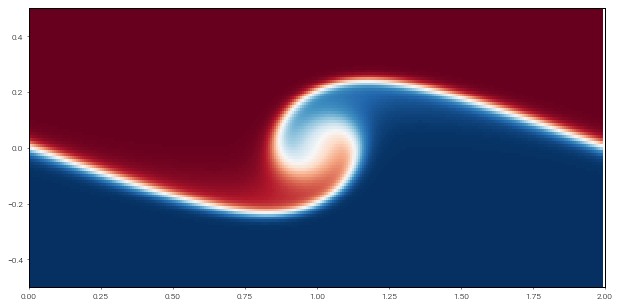

In [12]:
# Make plot of scalar field
x = domain.grid(0,scales=domain.dealias)
y = domain.grid(1,scales=domain.dealias)
xm, ym = np.meshgrid(x,y)
fig, axis = plt.subplots(figsize=(10,5))
p = axis.pcolormesh(xm, ym, s['g'].T, cmap='RdBu_r');
axis.set_xlim([0,2.])
axis.set_ylim([-0.5,0.5])

logger.info('Starting loop')
start_time = time.time()
while solver.ok:
    dt = cfl.compute_dt()
    solver.step(dt)
    if solver.iteration % 10 == 0:
        # Update plot of scalar field
        p.set_array(np.ravel(s['g'][:-1,:-1].T))
        display.clear_output()
        display.display(plt.gcf())
        logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))

end_time = time.time()

p.set_array(np.ravel(s['g'][:-1,:-1].T))
display.clear_output()
# Print statistics
logger.info('Run time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)

## Analysis

As an example of doing some analysis, we will load in the horizontally averaged profiles of the scalar field $s$ and plot them.

In [21]:
# Read in the data
f = h5py.File('analysis_tasks/analysis_tasks_s1/analysis_tasks_s1_p0.h5','r')
y = f['/scales/y/1.0'][:]
t = f['scales']['sim_time'][:]
s_ave = f['tasks']['s profile'][:]
f.close()

s_ave = s_ave[:,0,:] # remove length-one x dimension

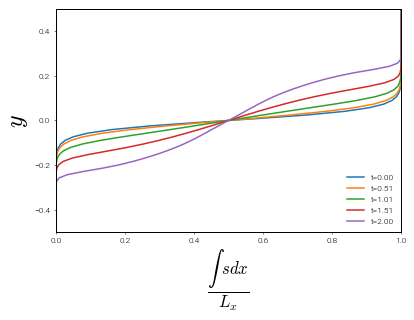

In [23]:
for i in range(0,21,5):
  plt.plot(s_ave[i,:],y,label='t=%4.2f' %t[i])

plt.ylim([-0.5,0.5])
plt.xlim([0,1])
plt.xlabel(r'$\frac{\int \ s dx}{L_x}$',fontsize=24)
plt.ylabel(r'$y$',fontsize=24)
plt.legend(loc='lower right').draw_frame(False)